In [1]:
import pandas as pd
# import pandas_datareader
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Download stock price of google
stock = yf.download('GOOG', start = '2010-01-01', end = '2014-12-31')
stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,311.208527,311.532288,308.832428,308.832428,308.832428,2448700
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927000
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031900
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987100
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876600


In [3]:
# Sample Data
stock['Value'] = stock['Close']*stock['Volume']
stock = stock[['Open', 'High', 'Low', 'Close', 'Volume', 'Value']]
stock.columns =  ['open', 'high', 'low', 'close', 'volume', 'value']
stock.index = stock.index.set_names(['t'])
stock.head()

,open,high,low,close,volume,value
t,,,,,,
2009-12-31,311.208527,311.532288,308.832428,308.832428,2448700,7.562380e+08
2010-01-04,312.304413,313.579620,310.954468,312.204773,3927000,1.226028e+09
2010-01-05,312.418976,312.747742,309.609497,310.829926,6031900,1.874895e+09
2010-01-06,311.761444,311.761444,302.047852,302.994293,7987100,2.420046e+09
2010-01-07,303.562164,303.861053,295.218445,295.940735,12876600,3.810710e+09


# Tick data

source : https://hwangheek.github.io/2020/pandas-tick-data/

data : DataFrame
    
    1) t : time
    1) open
    2) high
    3) low
    4) close
    5) volume
    6) value  =  close x volume

In [4]:
class Tick:
    def __init__(self, data, bench = 'close'):
        self.data = data
        self.bench = bench        
        
    #--- 시간바 -----#
    def timebar(self, rule = '1d'):
        # rule : sampling 하는 시간 간격
        tick = self.data
        resample = tick.resample(rule)
        
        bars = resample[self.bench].ohlc()
        
        # 거래가 일어나지 않은 시간의 NaN 처리
        bars['close'] = bars['close'].fillna(method='ffill')
        bars['open']  = bars['open'].fillna(bars['close'])
        bars['high']  = bars['high'].fillna(bars['close'])
        bars['low']  = bars['low'].fillna(bars['close'])
        bars[['volume', 'value']] = resample[['volume', 'value']].sum()
        return bars
    
    #---- 틱바 -----#
    def tickbar(self, window_size = 10):
        tick = self.data
        tick = tick.reset_index(['t'])

        tick['window_number'] = np.arange(len(tick)) // window_size
        groupby = tick.groupby('window_number')

        bars = groupby[self.bench].ohlc()
        bars[['volume', 'value']] = groupby[['volume', 'value']].sum()
        bars['t'] = groupby['t'].first()

        bars.set_index('t', inplace=True)

        return bars
    
    #---- 거래량 바 ----#
    def naive_volumebar(self, unit_volume = 50000):
        tick = self.data
        tick = tick.reset_index()

        tick['window_number'] = tick['volume'].cumsum() // unit_volume
        groupby = tick.groupby('window_number')

        bars = groupby[self.bench].ohlc()
        bars[['volume', 'value']] = groupby[['volume', 'value']].sum()
        bars['t'] = groupby['t'].first()

        bars.set_index('t', inplace=True)

        return bars
    
    #---- 달러바 ----#
    def naive_dollarbar(self, unit_value = 50000):
        tick = self.data
        tick = tick.reset_index(['t'])

        tick['window_number'] = tick['value'].cumsum() // unit_value
        groupby = tick.groupby('window_number')

        bars = groupby[self.bench].ohlc()
        bars[['volume', 'value']] = groupby[['volume', 'value']].sum()
        bars['t'] = groupby['t'].first()

        bars.set_index('t', inplace=True)

        return bars

In [5]:
tick = Tick(stock)
timebar_data = tick.timebar(rule = '2d')
tickbar_data = tick.tickbar()
volumebar_data = tick.naive_volumebar()
dollarbar_data = tick.naive_dollarbar()

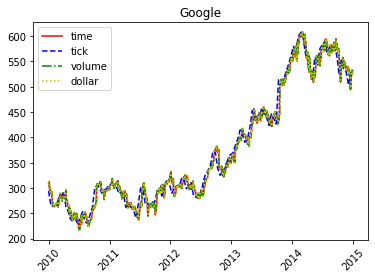

In [6]:
plt.plot(timebar_data['close'], c = 'r', label = 'time', linestyle = '-')
plt.plot(tickbar_data['close'], c = 'b', label = 'tick',  linestyle = '--')
plt.plot(volumebar_data['close'], c = 'g', label = 'volume', linestyle = '-.')
plt.plot(dollarbar_data['close'], c = 'y', label = 'dollar', linestyle = ':')
plt.legend(loc = 'best')
plt.title('Google')
plt.xticks(rotation = '45')
plt.show()